In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [ ]:
! rm -rf /kaggle/working/data/

# Reading input data

In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/DULIEU_MOI_SKINCANCER/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/DULIEU_MOI_SKINCANCER/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
batch_size = 32
img_height = 75
img_width = 100
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


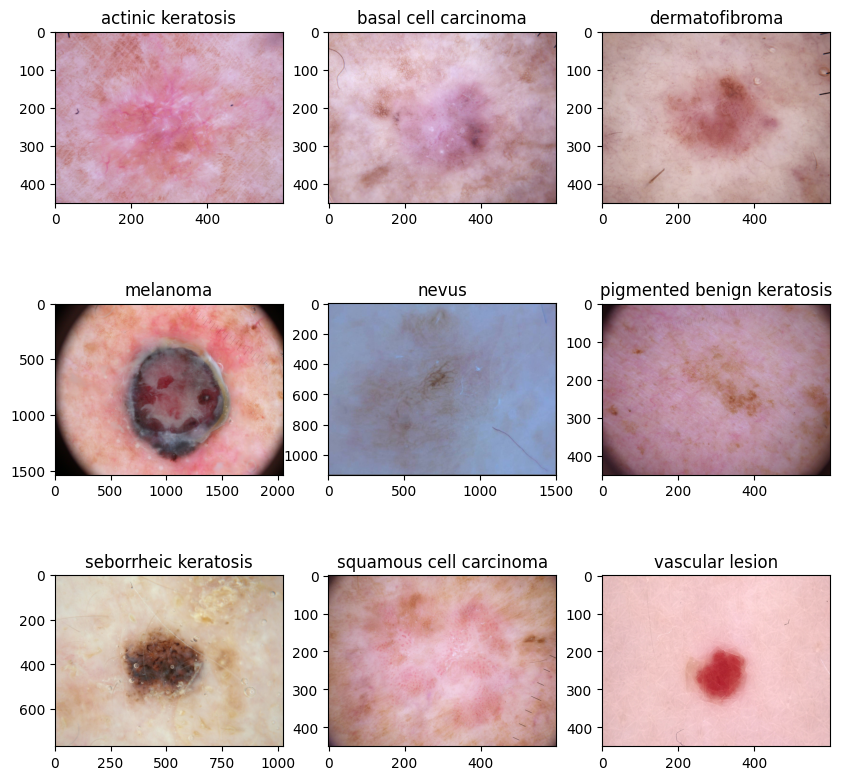

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 75, 100, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model


In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
num_classes = 9

model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 3, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 512)               3146240   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 10188361 (38.87 MB)
Trainable params: 10104713 (38.55 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 277s 4s/step - loss: 2.3387 - accuracy: 0.4174 - val_loss: 7.3480 - val_accuracy: 0.2394
Epoch 2/10
56/56 [==============================] - 201s 4s/step - loss: 1.2567 - accuracy: 0.5798 - val_loss: 57.6574 - val_accuracy: 0.2841
Epoch 3/10
56/56 [==============================] - 218s 4s/step - loss: 1.0004 - accuracy: 0.6590 - val_loss: 2.0901 - val_accuracy: 0.5682
Epoch 4/10
56/56 [==============================] - 202s 4s/step - loss: 0.8186 - accuracy: 0.7054 - val_loss: 2.4533 - val_accuracy: 0.3669
Epoch 5/10
56/56 [==============================] - 216s 4s/step - loss: 0.6756 - accuracy: 0.7640 - val_loss: 1.9932 - val_accuracy: 0.5526
Epoch 6/10
56/56 [==============================] - 212s 4s/step - loss: 0.6154 - accuracy: 0.7801 - val_loss: 2.0787 - val_accuracy: 0.4385
Epoch 7/10
56/56 [==============================] - 212s 4s/step - loss: 0.5282 - accuracy: 0.7969 - val_loss: 2.2991 - val_accuracy: 0.4206
Epoch 8/10
5

In [ ]:
from keras.callbacks import EarlyStopping

opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/20
56/56 [==============================] - 247s 4s/step - loss: 0.8334 - accuracy: 0.7221 - val_loss: 434.8620 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 204s 4s/step - loss: 0.6400 - accuracy: 0.7785 - val_loss: 3.5886 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 200s 4s/step - loss: 0.5181 - accuracy: 0.8231 - val_loss: 28.8917 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 212s 4s/step - loss: 0.4992 - accuracy: 0.8209 - val_loss: 3.0345 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 201s 4s/step - loss: 0.5041 - accuracy: 0.8181 - val_loss: 3.5473 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 201s 4s/step - loss: 0.4724 - accuracy: 0.8421 - val_loss: 2.8476 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 211s 4s/step - loss: 0.4652 - accuracy: 0.8426 - val_loss: 1.7586 - val_accuracy: 0.5190
Epoch 8/20

In [ ]:
opt = Adam(lr=0.0001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/30
56/56 [==============================] - 251s 4s/step - loss: 0.4881 - accuracy: 0.8309 - val_loss: 2.7169 - val_accuracy: 0.4497
Epoch 2/30
56/56 [==============================] - 213s 4s/step - loss: 0.3807 - accuracy: 0.8605 - val_loss: 4.4916 - val_accuracy: 0.4161
Epoch 3/30
56/56 [==============================] - 204s 4s/step - loss: 0.3403 - accuracy: 0.8677 - val_loss: 2.2796 - val_accuracy: 0.5861
Epoch 4/30
56/56 [==============================] - 211s 4s/step - loss: 0.3703 - accuracy: 0.8622 - val_loss: 5.2696 - val_accuracy: 0.4430
Epoch 5/30
56/56 [==============================] - 212s 4s/step - loss: 0.2896 - accuracy: 0.8850 - val_loss: 4.1310 - val_accuracy: 0.3691
Epoch 6/30
56/56 [==============================] - 212s 4s/step - loss: 0.3528 - accuracy: 0.8711 - val_loss: 2.4817 - val_accuracy: 0.4810
Epoch 7/30
56/56 [==============================] - 204s 4s/step - loss: 0.2430 - accuracy: 0.8968 - val_loss: 2.9889 - val_accuracy: 0.5772
Epoch 8/30
56

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/50
56/56 [==============================] - 249s 4s/step - loss: 0.2950 - accuracy: 0.8906 - val_loss: 5.1862 - val_accuracy: 0.5615
Epoch 2/50
56/56 [==============================] - 202s 4s/step - loss: 0.2154 - accuracy: 0.9113 - val_loss: 7.3797 - val_accuracy: 0.4385
Epoch 3/50
56/56 [==============================] - 204s 4s/step - loss: 0.2926 - accuracy: 0.8823 - val_loss: 3.9031 - val_accuracy: 0.4273
Epoch 4/50
56/56 [==============================] - 204s 4s/step - loss: 0.2804 - accuracy: 0.8901 - val_loss: 21.8299 - val_accuracy: 0.4362
Epoch 5/50
56/56 [==============================] - 203s 4s/step - loss: 0.3340 - accuracy: 0.8884 - val_loss: 6.0882 - val_accuracy: 0.3960
Epoch 6/50
56/56 [==============================] - 214s 4s/step - loss: 0.3084 - accuracy: 0.8839 - val_loss: 1.8935 - val_accuracy: 0.5660
Epoch 7/50
56/56 [==============================] - 205s 4s/step - loss: 0.1864 - accuracy: 0.9213 - val_loss: 7.6995 - val_accuracy: 0.3468
Epoch 8/50
5

In [ ]:
opt = Adam(lr=0.00001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 70
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/70
56/56 [==============================] - 258s 4s/step - loss: 0.3258 - accuracy: 0.8778 - val_loss: 8.8972 - val_accuracy: 0.3468
Epoch 2/70
56/56 [==============================] - 206s 4s/step - loss: 0.2497 - accuracy: 0.9096 - val_loss: 2.9166 - val_accuracy: 0.5593
Epoch 3/70
56/56 [==============================] - 205s 4s/step - loss: 0.2915 - accuracy: 0.8934 - val_loss: 9.9175 - val_accuracy: 0.3289
Epoch 4/70
56/56 [==============================] - 214s 4s/step - loss: 0.2402 - accuracy: 0.9113 - val_loss: 6.2668 - val_accuracy: 0.3624
Epoch 5/70
56/56 [==============================] - 206s 4s/step - loss: 0.1849 - accuracy: 0.9141 - val_loss: 2.3211 - val_accuracy: 0.5928
Epoch 6/70
56/56 [==============================] - 204s 4s/step - loss: 0.1382 - accuracy: 0.9358 - val_loss: 2.6868 - val_accuracy: 0.5727
Epoch 7/70
56/56 [==============================] - 204s 4s/step - loss: 0.1725 - accuracy: 0.9342 - val_loss: 4.3614 - val_accuracy: 0.4004
Epoch 8/70
56

In [ ]:
opt = Adam(lr=0.00001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/100
56/56 [==============================] - 250s 4s/step - loss: 0.2495 - accuracy: 0.9196 - val_loss: 3.8257 - val_accuracy: 0.4832
Epoch 2/100
56/56 [==============================] - 212s 4s/step - loss: 0.2214 - accuracy: 0.9118 - val_loss: 58.0105 - val_accuracy: 0.3311
Epoch 3/100
56/56 [==============================] - 214s 4s/step - loss: 0.3371 - accuracy: 0.8945 - val_loss: 43.9795 - val_accuracy: 0.2528
Epoch 4/100
56/56 [==============================] - 202s 4s/step - loss: 0.2009 - accuracy: 0.9196 - val_loss: 3.3412 - val_accuracy: 0.5749
Epoch 5/100
56/56 [==============================] - 215s 4s/step - loss: 0.1344 - accuracy: 0.9414 - val_loss: 2.9971 - val_accuracy: 0.5369
Epoch 6/100
56/56 [==============================] - 214s 4s/step - loss: 0.1112 - accuracy: 0.9475 - val_loss: 2.4890 - val_accuracy: 0.5570
Epoch 7/100
56/56 [==============================] - 214s 4s/step - loss: 0.1033 - accuracy: 0.9537 - val_loss: 3.3954 - val_accuracy: 0.4966
Epoc

In [ ]:
opt = Adam(lr=0.000001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=(early_stopping)
)

Epoch 1/150
56/56 [==============================] - 262s 4s/step - loss: 0.2170 - accuracy: 0.9202 - val_loss: 7.6350 - val_accuracy: 0.5414
Epoch 2/150
56/56 [==============================] - 206s 4s/step - loss: 0.3253 - accuracy: 0.9079 - val_loss: 11.6195 - val_accuracy: 0.4743
Epoch 3/150
56/56 [==============================] - 207s 4s/step - loss: 0.2902 - accuracy: 0.9124 - val_loss: 4.2011 - val_accuracy: 0.4318
Epoch 4/150
56/56 [==============================] - 205s 4s/step - loss: 0.1336 - accuracy: 0.9381 - val_loss: 2.8346 - val_accuracy: 0.5884
Epoch 5/150
56/56 [==============================] - 216s 4s/step - loss: 0.0938 - accuracy: 0.9487 - val_loss: 4.7055 - val_accuracy: 0.4944
Epoch 6/150
56/56 [==============================] - 207s 4s/step - loss: 0.0801 - accuracy: 0.9626 - val_loss: 3.0076 - val_accuracy: 0.6107
Epoch 7/150
56/56 [==============================] - 216s 4s/step - loss: 0.0893 - accuracy: 0.9542 - val_loss: 3.1736 - val_accuracy: 0.6063
Epoch

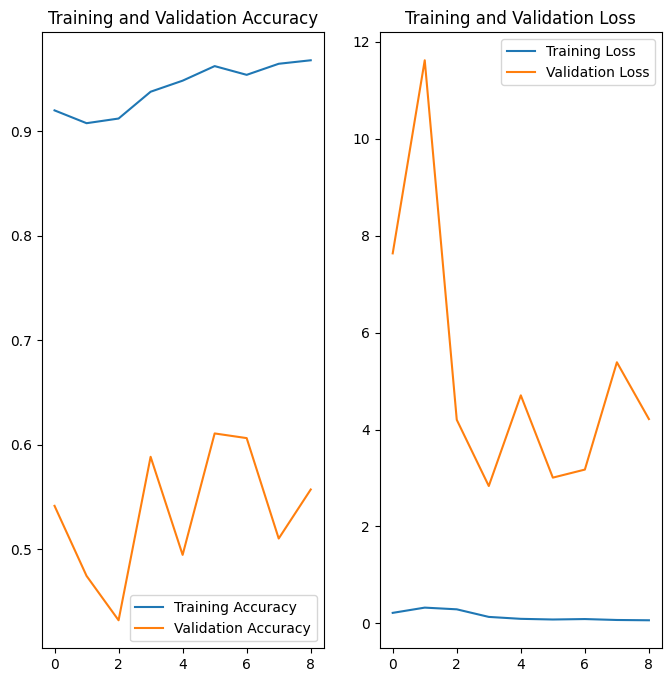

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
